# Request Log Analysis

## Functionalities
- Display a summary of requests and their performance metrics.

## Input
Log files are read from a directory in `../data`. This directory is assumed to have the following structure:
```
logs/
  [node-1]/
    loadgen.tar.gz
  ...
  [node-n]/
    loadgen.tar.gz
```
A tarball `loadgen.tar.gz` contains a request log file named `loadgen.log`.

## Notebook Configuration

In [1]:
########## GENERAL
# Name of the directory in `../data`
EXPERIMENT_DIRNAME = "BuzzBlogBenchmark_2021-11-23-16-32-52"
# Ramp up duration (in sec)
RAMP_UP_DURATION = 60
# Ramp down duration (in sec)
RAMP_DOWN_DURATION = 60

########## LATENCY
# Max expected value
MAX_LATENCY_IN_S = 1
# Bin size
LATENCY_BIN_IN_MS = 50

## Notebook Setup

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
import warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.abspath(os.path.join("..")))
from parsers.loadgen_parser import LoadgenParser
from utils.utils import *

## Log Parsing

In [3]:
# Build data frame
requests = pd.concat(
    [pd.DataFrame.from_dict(LoadgenParser(logfile).parse()) for logfile in get_loadgen_logfiles(EXPERIMENT_DIRNAME)],
    ignore_index=True)

In [4]:
# (Re) Build columns
start_time = get_experiment_start_time(EXPERIMENT_DIRNAME)
requests["timestamp"] = requests.apply(lambda r: (r["timestamp"] - start_time).total_seconds(), axis=1)
requests["window"] = requests.apply(lambda r: int(r["timestamp"]), axis=1)

In [5]:
# (Re) Create index
requests.set_index("timestamp", inplace=True)

## Status of Requests

<AxesSubplot:title={'center':'Number of successful/failed requests'}>

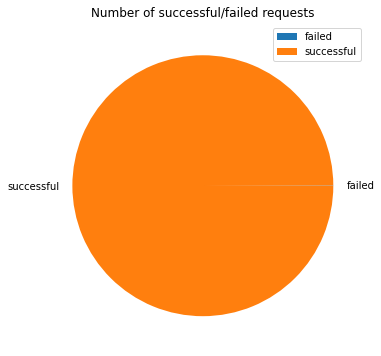

In [6]:
fig = plt.figure(figsize=(18, 6))
ax = fig.gca()
df = requests.groupby(["status"]).count()["method"]
df.plot(ax=ax, kind="pie", title="Number of successful/failed requests", xlabel="", ylabel="", legend=True)

<AxesSubplot:title={'center':'HTTP status code of failed requests'}>

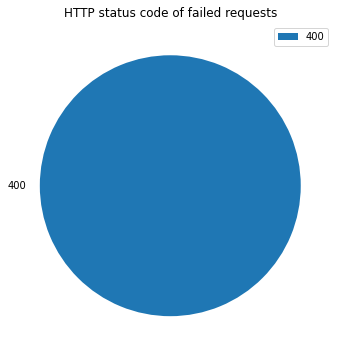

In [7]:
fig = plt.figure(figsize=(18, 6))
ax = fig.gca()
df = requests[requests["status"] == "failed"].groupby(["status_code"]).count()["method"]
df.plot(ax=ax, kind="pie", title="HTTP status code of failed requests", xlabel="", ylabel="", legend=True)

## Type of Requests

<AxesSubplot:title={'center':'Number of read/write requests'}>

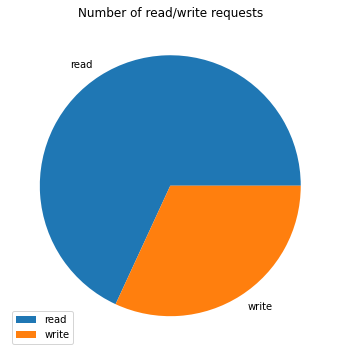

In [8]:
fig = plt.figure(figsize=(18, 6))
ax = fig.gca()
df = requests.groupby(["rw"]).count()["method"]
df.plot(ax=ax, kind="pie", title="Number of read/write requests", xlabel="", ylabel="", legend=True)

<AxesSubplot:title={'center':'Number of requests of each type'}, ylabel='Requests (count)'>

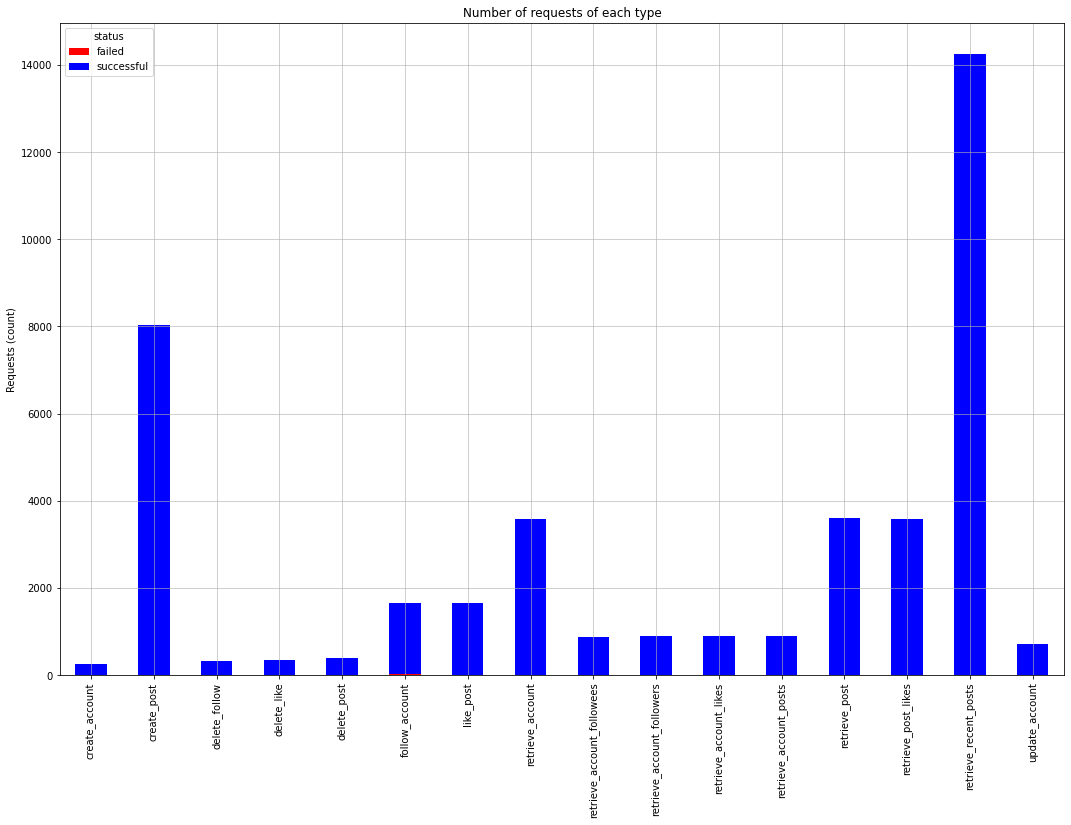

In [9]:
fig = plt.figure(figsize=(18, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
df = requests.groupby(["type", "status"]).count()["method"].unstack().fillna(0)
df.plot(ax=ax, kind="bar", stacked=True, title="Number of requests of each type", xlabel="", ylabel="Requests (count)",
        color={"failed": "red", "successful": "blue"}, legend=True, grid=True)

## Request Latency Distribution

<AxesSubplot:title={'center':'Latency Distribution of Successful Requests Excluding Ramping Periods'}, xlabel='Latency (seconds)', ylabel='Frequency'>

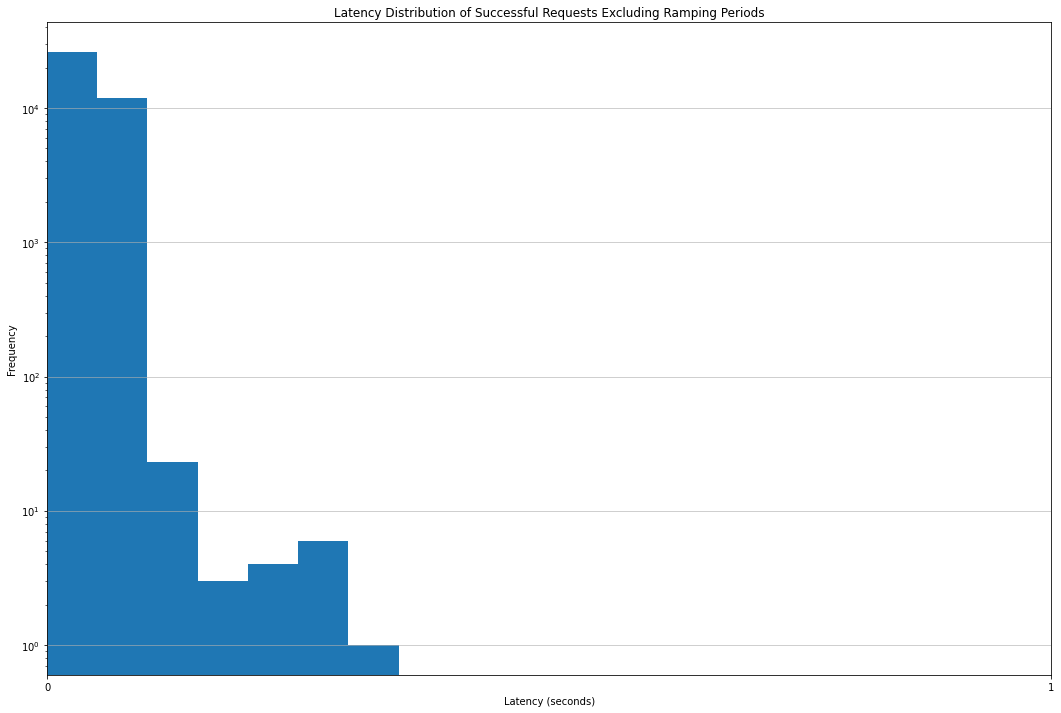

In [10]:
fig = plt.figure(figsize=(18, 12))
ax = fig.gca(xlabel="Latency (seconds)", ylabel="Requests (count)")
ax.grid(alpha=0.75)
ax.set_yscale("log")
ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S))
ax.set_xticks(range(0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S + 1, (1000 // LATENCY_BIN_IN_MS)))
ax.set_xticklabels([str(s) for s in range(MAX_LATENCY_IN_S + 1)])
df = requests[requests["status"] == "successful"]
df = df[(df.index >= RAMP_UP_DURATION) & (df.index <= requests.index.max() - RAMP_DOWN_DURATION)]
df["latency_bin"] = df.apply(lambda r: int(r["latency"] * 1000 // LATENCY_BIN_IN_MS), axis=1)
df["latency_bin"].plot(ax=ax, kind="hist",
        title="Latency Distribution of Successful Requests Excluding Ramping Periods",
        bins=range((1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S), grid=True)

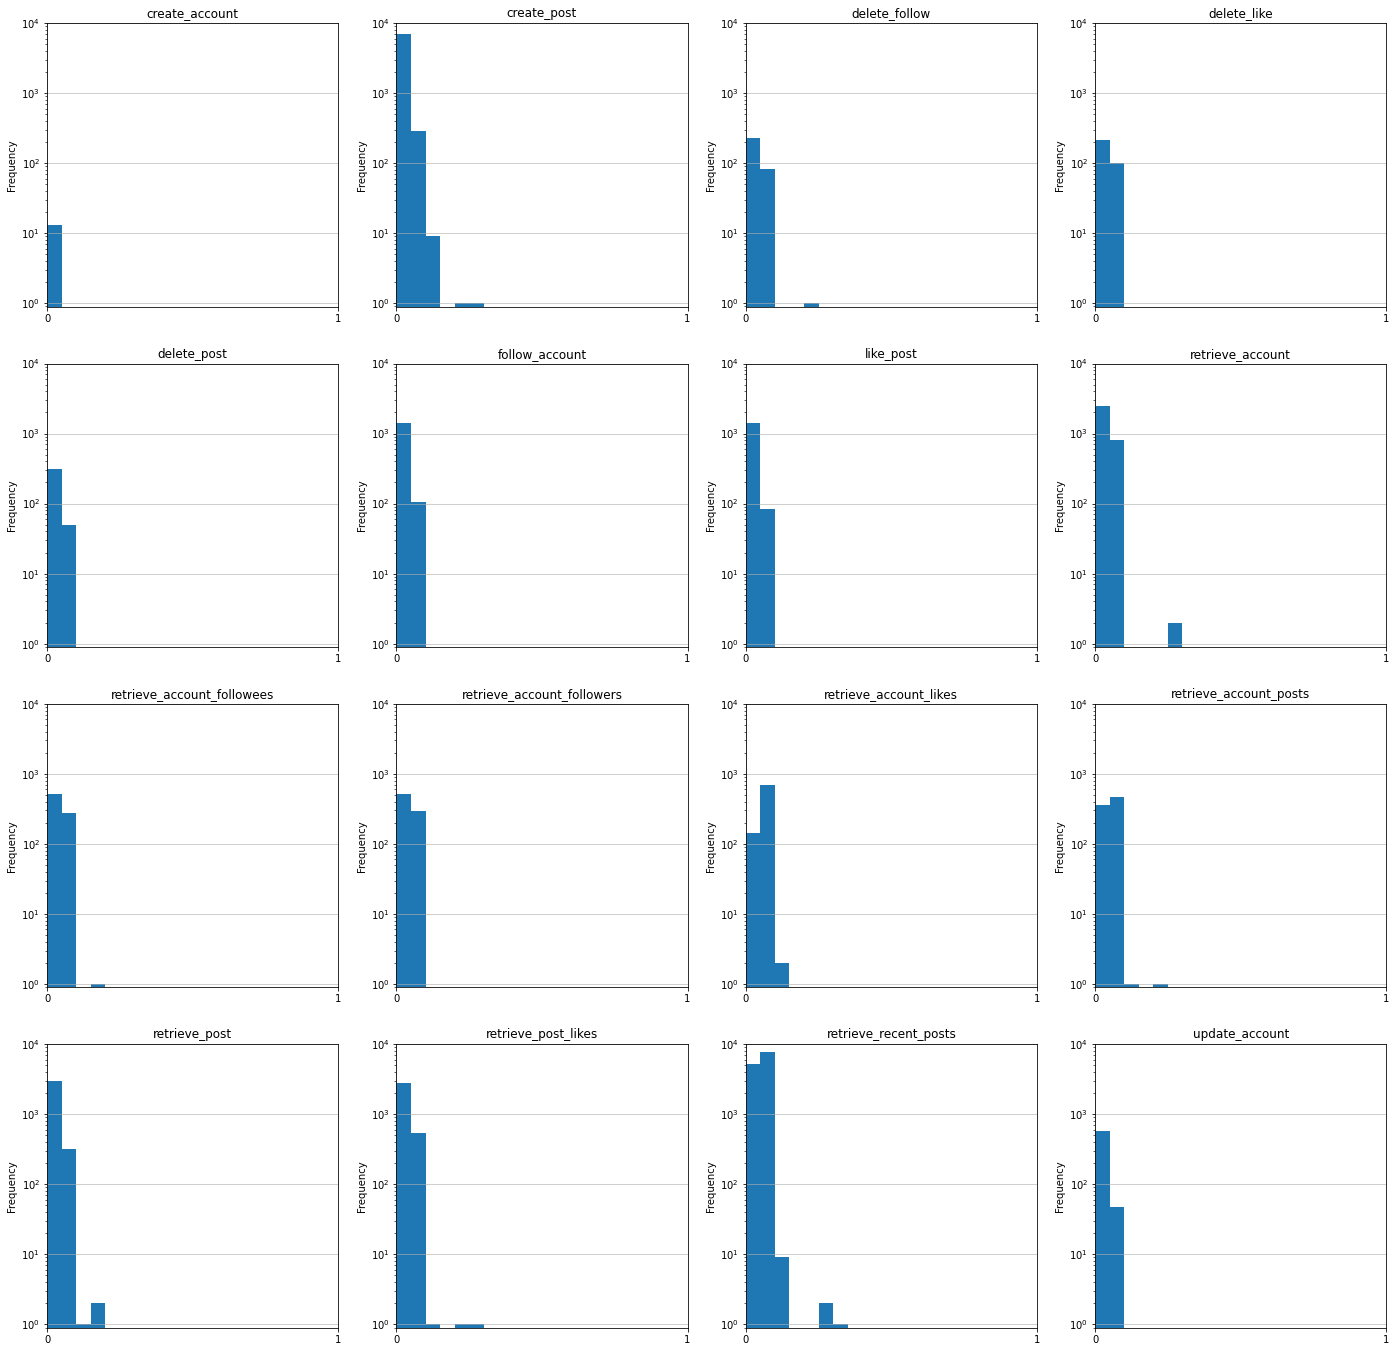

In [11]:
fig = plt.figure(figsize=(24, 24))
for (i, (request_type, _)) in enumerate(requests.groupby(["type"])):
  ax = fig.add_subplot(4, 4, i + 1)
  ax.grid(alpha=0.75)
  ax.set_yscale("log")
  ax.set_xlim((0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S))
  ax.set_ylim((0, 10000))
  ax.set_xticks(range(0, (1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S + 1, (1000 // LATENCY_BIN_IN_MS)))
  ax.set_xticklabels([str(s) for s in range(MAX_LATENCY_IN_S + 1)])
  df = requests[(requests["status"] == "successful") & (requests["type"] == request_type)]
  df = df[(df.index >= RAMP_UP_DURATION) & (df.index <= requests.index.max() - RAMP_DOWN_DURATION)]
  df["latency_bin"] = df.apply(lambda r: int(r["latency"] * 1000 // LATENCY_BIN_IN_MS), axis=1)
  df["latency_bin"].plot(ax=ax, kind="hist", title=request_type, xlabel="Latency (seconds)", ylabel="Requests (count)",
      bins=range((1000 // LATENCY_BIN_IN_MS) * MAX_LATENCY_IN_S), grid=True)

## Request Latency

<AxesSubplot:title={'center':'Latency of Successful Requests'}, xlabel='Time (seconds)', ylabel='Latency (seconds)'>

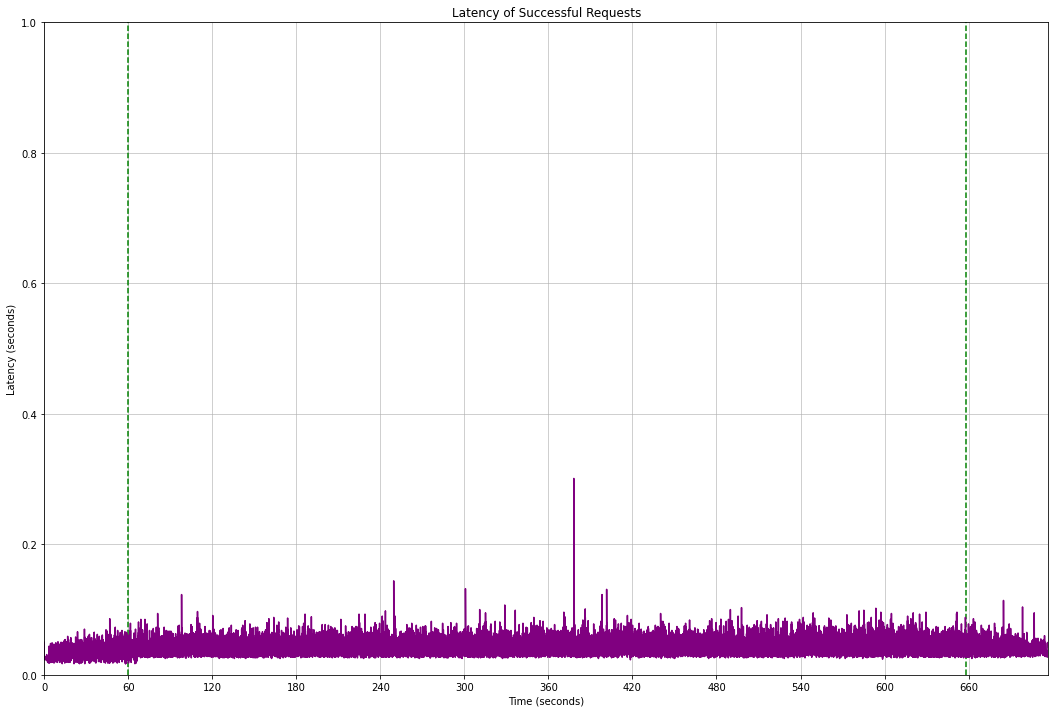

In [12]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = None
# Maximum time (in seconds)
MAX_TIME = None

fig = plt.figure(figsize=(18, 12))
df = requests[requests["status"] == "successful"]
if MIN_TIME:
    df = df[(df.index >= MIN_TIME)]
if MAX_TIME:
    df = df[(df.index <= MAX_TIME)]
ax = fig.gca()
ax.grid(alpha=0.75)
ax.set_xlim((int(df.index.min()), int(df.index.max())))
ax.set_ylim((0, MAX_LATENCY_IN_S))
ax.axvline(x=RAMP_UP_DURATION, ls="--", color="green")
ax.axvline(x=requests.index.values.max() - RAMP_DOWN_DURATION, ls="--", color="green")
df["latency"].plot(ax=ax, kind="line", title="Latency of Successful Requests", xlabel="Time (seconds)",
        ylabel="Latency (seconds)", color="purple", grid=True,
        xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60))

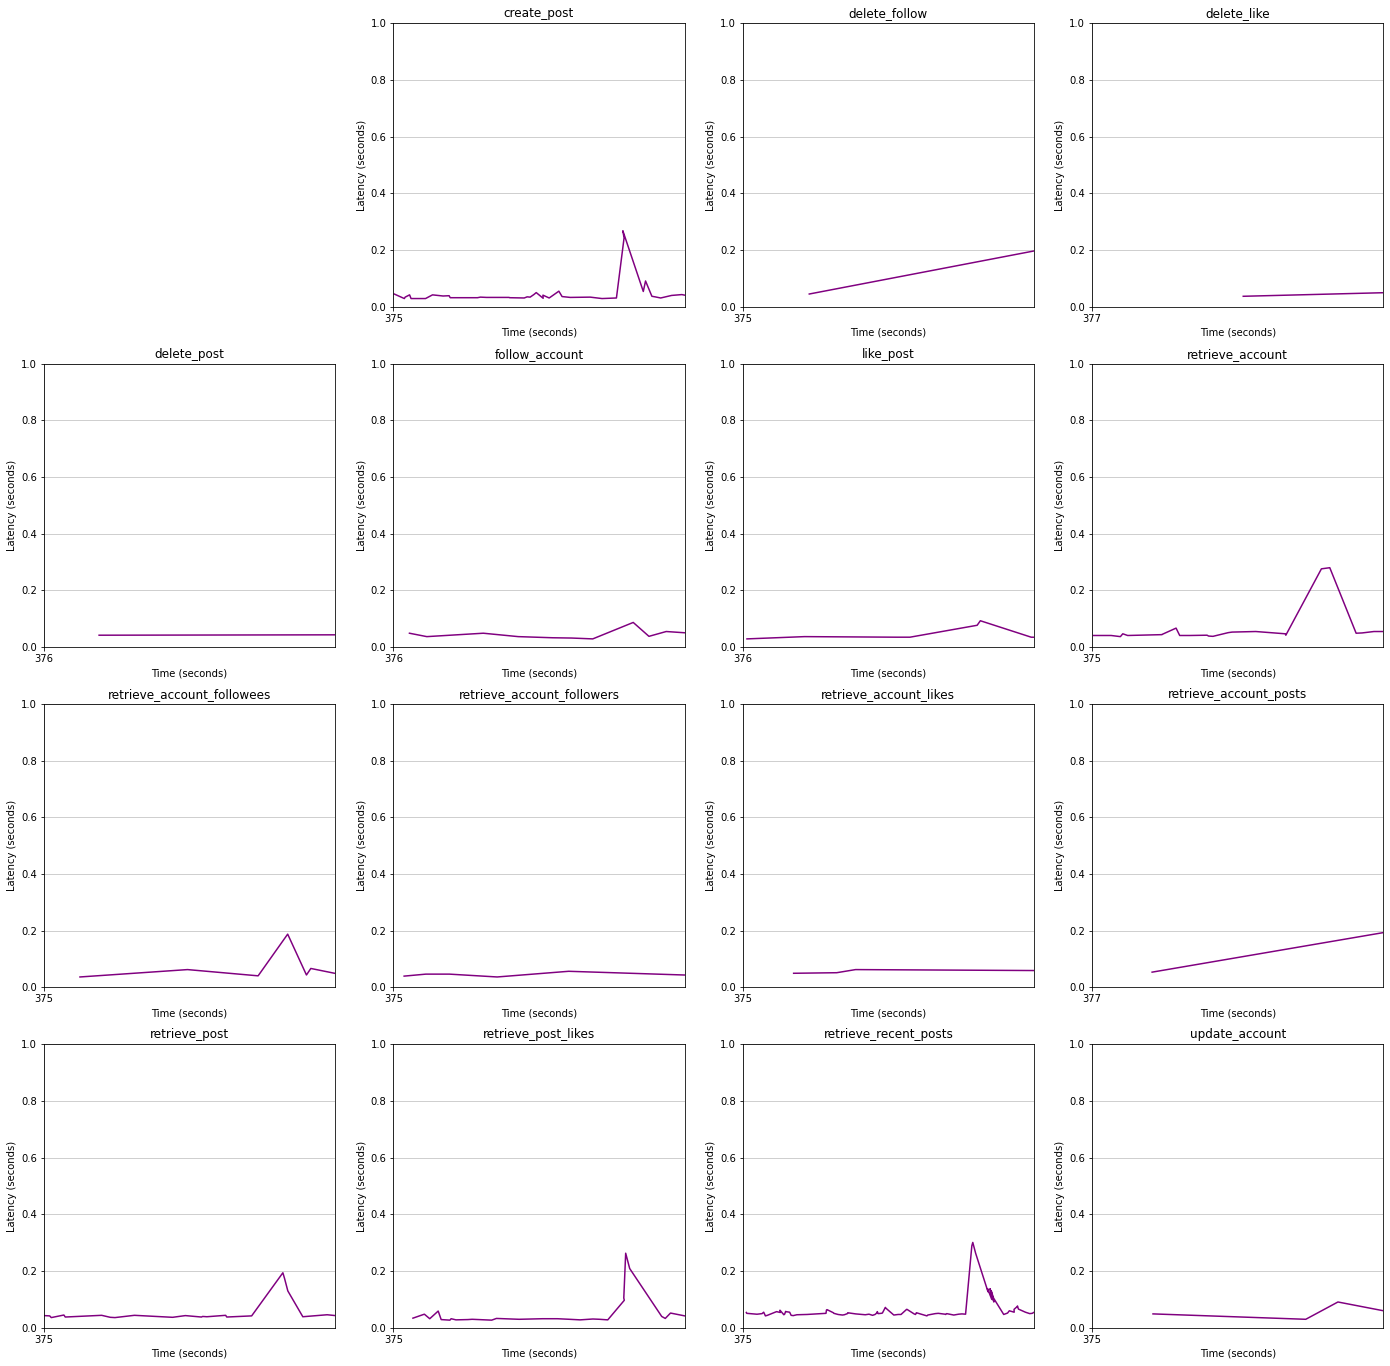

In [17]:
########## LOCAL CONFIG
# Minimum time (in seconds)
MIN_TIME = 375
# Maximum time (in seconds)
MAX_TIME = 380

fig = plt.figure(figsize=(24, 24))
for (i, (request_type, _)) in enumerate(requests.groupby(["type"])):
  df = requests[(requests["status"] == "successful") & (requests["type"] == request_type)]
  if MIN_TIME:
    df = df[(df.index >= MIN_TIME)]
  if MAX_TIME:
    df = df[(df.index <= MAX_TIME)]
  if df.empty:
    continue
  ax = fig.add_subplot(4, 4, i + 1)
  ax.grid(alpha=0.75)
  ax.set_xlim((int(df.index.min()), int(df.index.max())))
  ax.set_ylim((0, MAX_LATENCY_IN_S))
  ax.axvline(x=RAMP_UP_DURATION, ls="--", color="green")
  ax.axvline(x=requests.index.values.max() - RAMP_DOWN_DURATION, ls="--", color="green")
  df["latency"].plot(ax=ax, kind="line", title=request_type, xlabel="Time (seconds)",
      ylabel="Latency (seconds)", color="purple", grid=True,
      xticks=range(int(df.index.min()), int(df.index.max()) + 1, 60))

## Request Throughput

<AxesSubplot:title={'center':'Throughput (requests per second)'}, xlabel='Time (seconds)', ylabel='Requests (count)'>

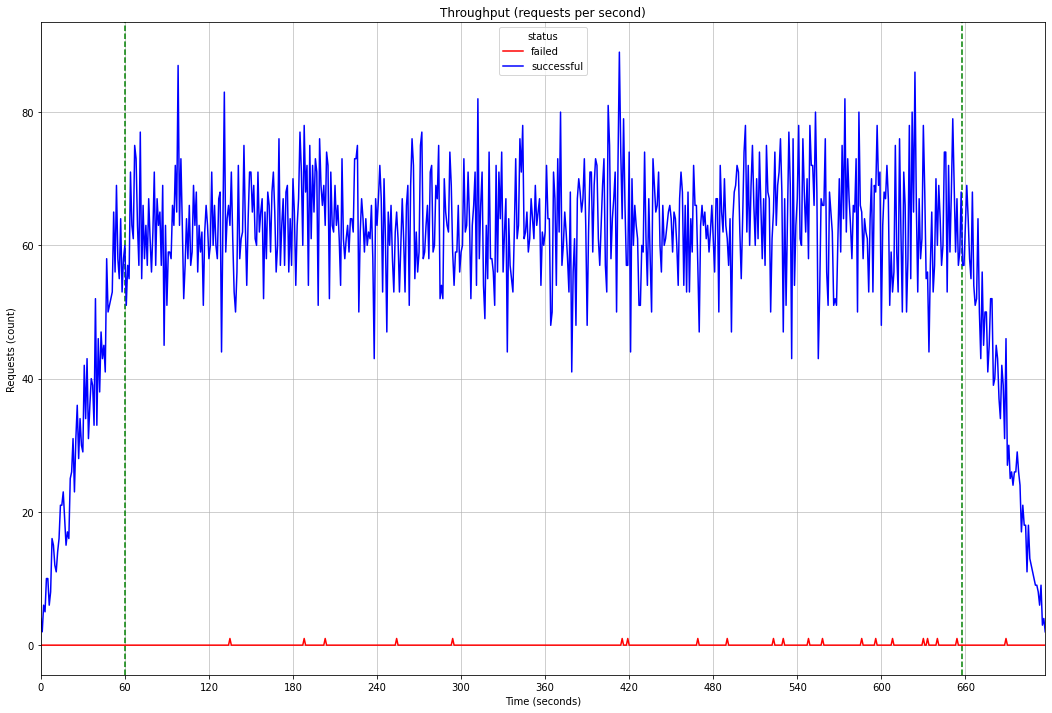

In [14]:
fig = plt.figure(figsize=(18, 12))
ax = fig.gca()
ax.grid(alpha=0.75)
ax.axvline(x=RAMP_UP_DURATION, ls="--", color="green")
ax.axvline(x=requests.index.values.max() - RAMP_DOWN_DURATION, ls="--", color="green")
df = requests.groupby(["window", "status"])["window"].count().unstack().fillna(0)
df = df.reindex(range(0, int(df.index.max()) + 1), fill_value=0)
ax.set_xlim((int(df.index.min()), int(df.index.max())))
df.plot(ax=ax, kind="line", title="Throughput (requests per second)", xlabel="Time (seconds)",
        ylabel="Requests (count)", color={"failed": "red", "successful": "blue"}, legend=True, grid=True,
        xticks=range(0, int(df.index.max()) + 1, 60))

## Summary

In [15]:
print("Number of requests")
print("  Total:       %7d" % requests.shape[0])
print("  Status")
print("    Failed:    %7d (%9.5f%%)" % (requests[requests["status"] == "failed"]["status"].count(),
    (requests[requests["status"] == "failed"]["status"].count() / requests.shape[0]) * 100))
print("    Succesful: %7d (%9.5f%%)" % (requests[requests["status"] == "successful"]["status"].count(),
    (requests[requests["status"] == "successful"]["status"].count() / requests.shape[0]) * 100))
print("  Type")
print("    Read:      %7d (%9.5f%%)" % (requests[requests["rw"] == "read"]["rw"].count(),
    (requests[requests["rw"] == "read"]["rw"].count() / requests.shape[0]) * 100))
print("    Write:     %7d (%9.5f%%)" % (requests[requests["rw"] == "write"]["rw"].count(),
    (requests[requests["rw"] == "write"]["rw"].count() / requests.shape[0]) * 100))
print("Experiment duration (s)")
print("  Total:       %7.3f" % requests.index.values.max())
print("Latency (ms)")
print("P99.9:         %7.2f" % (requests[requests["status"] == "successful"]["latency"].quantile(0.999) * 1000))
print("  P99:         %7.2f" % (requests[requests["status"] == "successful"]["latency"].quantile(0.99) * 1000))
print("  P95:         %7.2f" % (requests[requests["status"] == "successful"]["latency"].quantile(0.95) * 1000))
print("  P50:         %7.2f" % (requests[requests["status"] == "successful"]["latency"].quantile(0.50) * 1000))
print("  Avg:         %7.2f" % (requests[requests["status"] == "successful"]["latency"].mean() * 1000))
print("  Std:         %7.2f" % (requests[requests["status"] == "successful"]["latency"].std() * 1000))
print("Throughput (req/s)")
print("  P99:         %7.2f" % requests.groupby(["window"])["window"].count().reindex(range(0, int(requests["window"].max()) + 1), fill_value=0).quantile(0.99))
print("  P95:         %7.2f" % requests.groupby(["window"])["window"].count().reindex(range(0, int(requests["window"].max()) + 1), fill_value=0).quantile(0.95))
print("  P50:         %7.2f" % requests.groupby(["window"])["window"].count().reindex(range(0, int(requests["window"].max()) + 1), fill_value=0).quantile(0.50))
print("  Avg:         %7.2f" % requests.groupby(["window"])["window"].count().reindex(range(0, int(requests["window"].max()) + 1), fill_value=0).mean())
print("  Std:         %7.2f" % requests.groupby(["window"])["window"].count().reindex(range(0, int(requests["window"].max()) + 1), fill_value=0).std())

Number of requests
  Total:         41993
  Status
    Failed:         21 (  0.05001%)
    Succesful:   41972 ( 99.94999%)
  Type
    Read:        28604 ( 68.11611%)
    Write:       13389 ( 31.88389%)
Experiment duration (s)
  Total:       717.851
Latency (ms)
P99.9:           98.00
  P99:           76.00
  P95:           64.00
  P50:           44.00
  Avg:           44.64
  Std:           11.66
Throughput (req/s)
  P99:           80.00
  P95:           75.00
  P50:           62.00
  Avg:           58.49
  Std:           15.30
